# Introduction

The goal of this exercise is to develop a model that predicts a movie's popularity, using available categorical and numerical features.

The main obstacles encountered are the following:
  1) The dataset requires a lot of cleaning and feature engineering in order to be usable; 
  2) A huge part (~75%) of the entire dataset have two important variables missing and because of that, it needs to be deleted;
  3) There is a need to introduce a regression imputation for two different variables before developing a final model. 

In this exercise, the Movies Dataset available on Kaggle is used. For more information, please see below:
https://www.kaggle.com/rounakbanik/the-movies-dataset

# Importing libraries, first look at the data

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [38]:
import os

In [39]:
movies_data = open("movies_metadata.csv", encoding="utf8")

In [40]:
movies_dataset = pd.read_csv(movies_data)

C:\Users\Patrycja\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [41]:
movies_dataset.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [42]:
movies_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

# Data cleaning and feature engineering - categorical variables

In [43]:
#In this exercise, only a subset of all features will be used. Let us start with
#dropping unnecessary features and dealing with the missing data.
movies_dataset.drop(['belongs_to_collection','homepage', 'poster_path', 'tagline', 'video', 'release_date',
                      'overview', 'runtime', 'status','id', 'imdb_id', 'original_title', 'spoken_languages', 
                     'production_countries'],
                    axis = 1, inplace = True)

In [44]:
#Check how many null values are there.

movies_dataset.isnull().sum()

adult                    0
budget                   0
genres                   0
original_language       11
popularity               5
production_companies     3
revenue                  6
title                    6
vote_average             6
vote_count               6
dtype: int64

In [45]:
#Given how large is the dataset, there are not so many missing data points, so we will delete the corresponding rows.

movies_dataset.dropna(axis = 0, how = 'any', inplace = True)

In [46]:
#Let us see what is a distribution of the 'adult' variable's values.

movies_dataset['adult'].value_counts()

False    45440
True         9
Name: adult, dtype: int64

In [47]:
#Only a few rows contain True value for 'adult' feature. It means its variance is too low and the 
#contribution to the model developed will not be meaningful. Thus, this feature will be removed.

movies_dataset.drop('adult', axis = 1, inplace = True)

In [48]:
#Let's take a closer look to an 'original_language' variable.

movies_dataset['original_language'].unique()

array(['en', 'fr', 'zh', 'it', 'fa', 'nl', 'de', 'cn', 'ar', 'es', 'ru',
       'sv', 'ja', 'ko', 'sr', 'bn', 'he', 'pt', 'wo', 'ro', 'hu', 'cy',
       'vi', 'cs', 'da', 'no', 'nb', 'pl', 'el', 'sh', 'xx', 'mk', 'bo',
       'ca', 'fi', 'th', 'sk', 'bs', 'hi', 'tr', 'is', 'ps', 'ab', 'eo',
       'ka', 'mn', 'bm', 'zu', 'uk', 'af', 'la', 'et', 'ku', 'fy', 'lv',
       'ta', 'sl', 'tl', 'ur', 'rw', 'id', 'bg', 'mr', 'lt', 'kk', 'ms',
       'sq', 'qu', 'te', 'am', 'jv', 'tg', 'ml', 'hr', 'lo', 'ay', 'kn',
       'eu', 'ne', 'pa', 'ky', 'gl', 'uz', 'sm', 'mt', 'hy', 'iu', 'lb',
       'si'], dtype=object)

In [49]:
#This variable's values look reasonable. We might create a few buckets for languages with highest number
#of occurences and another called 'other' for minor ones, but firstly it is useful to check the distribution.

movies_dataset['original_language'].value_counts().head(8)

en    32267
fr     2438
it     1529
ja     1349
de     1080
es      994
ru      826
hi      508
Name: original_language, dtype: int64

In [50]:
#There are more than 30000 occurences of English, and the second highest value - French covers around 5% of the whole
#dataset. The desicion is to create 3 bins: English, French and Others.

#This function creates bins for 'original_language':

def language_binning(language):
    if language == 'en':
        return 'en';
    elif language == 'fr':
        return 'fr';
    else:
        return 'other'

In [51]:
#Now, we will apply binning for all rows in the dataset and this way, create a new dataset 'dummy_language'. 
#Then in this new dataset we will drop the column 'original_language_en'in order to avoid introducing unnecessary 
#multicollinearity. After that we will join the two datasets together ang get rid of 'original_language' feature.

movies_dataset['original_language'] = movies_dataset['original_language'].apply(language_binning)

In [52]:
dummy_language = pd.get_dummies(movies_dataset['original_language'], prefix = 'language', drop_first = True)

In [53]:
movies_dataset = pd.concat([movies_dataset, dummy_language], axis = 1)

In [54]:
movies_dataset.drop('original_language', axis = 1, inplace = True)

In [55]:
#Let us move on with other categorical features. What is the format of 'genres' and 'production_companies' features?

print(type(movies_dataset['genres'][0]) , type(movies_dataset['production_companies'][0]))

<class 'str'> <class 'str'>


In [56]:
#Right now, 'genres' and 'production_companies' are in an unusable format - they are stringified lists of dictionaries.
#Let us make lists out of them instead.

from ast import literal_eval

features = ['genres', 'production_companies']
for feature in features:
    movies_dataset[feature] = movies_dataset[feature].apply(literal_eval)

In [57]:
print(movies_dataset['genres'][0])
print(movies_dataset['production_companies'][0])

[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]
[{'name': 'Pixar Animation Studios', 'id': 3}]


In [58]:
#We can see above that for both features, the corresponding genre/production company goes as a value for 'name' key.
#Taking this into account, we will 'unpack' these dictionaries and leave only lists of these values.

def get_element(list_of_elements):
    if isinstance(list_of_elements, list):
        names = [element['name'] for element in list_of_elements]
        #Check if more than 4 elements exist. If yes, return only first four. If no, return entire list.
        if len(names) > 4:
            names = names[:4]
        return names

    #Return empty list in case of missing data
    return []

In [59]:
#Applying for the whole dataset.

for feature in features:
    movies_dataset[feature] = movies_dataset[feature].apply(get_element)

In [60]:
#Check
movies_dataset['production_companies'].head()

0                            [Pixar Animation Studios]
1    [TriStar Pictures, Teitler Film, Interscope Co...
2                       [Warner Bros., Lancaster Gate]
3             [Twentieth Century Fox Film Corporation]
4         [Sandollar Productions, Touchstone Pictures]
Name: production_companies, dtype: object

In [61]:
#There are a lot of different movie production companies. According to information taken from
#Wikipedia, we are going to manually create a list of major ones in order to see whether movies made by
#these companies become more popular. Finally, we are going to flag each movie based on
#whether the company that created it was or was not in the below list.

major_companies = ['Twentieth Century Fox Film Corporation', 'Metro-Goldwyn-Mayer',  
                    'New Line Cinema','Warner Bros.', 'Sony Pictures Entertainment',
                   'Pixar Animation Studios', 'Paramount Pictures',
                   'Columbia Pictures Corporation', 'Columbia Pictures',
                   'Walt Disney Pictures', 'Universal Pictures', 'Universal Studios', 'TriStar Pictures']

In [62]:
#Since it can be noticed two line above that for 'production_companies' values there are empty lists in some rows,
#we will replace them with 'unknown'. If a movie was produced by more than one company an at least one of them
#appears on the list, it will be classified as produced by a big company.

def big_company(list_of_companies):
    if not list_of_companies:
        return 'unknown'
    else:
        if any(company in major_companies for company in list_of_companies):
            return 'big_company'
        else:
            return 'small_company'

In [63]:
#We need to repeat steps similar to the previous dealing with 'original_language'.

movies_dataset['production_companies'] = movies_dataset['production_companies'].apply(big_company)

In [64]:
movies_dataset['production_companies'].value_counts()

small_company    28045
unknown          11871
big_company       5533
Name: production_companies, dtype: int64

In [65]:
dummy_company = pd.get_dummies(movies_dataset['production_companies'], prefix = 'company', drop_first = True)

In [66]:
movies_dataset = pd.concat([movies_dataset, dummy_company], axis = 1)

In [67]:
movies_dataset.drop('production_companies', axis = 1, inplace = True)

In [68]:
#Let us see what is a distribution of 'genres' variable. 
#First of all, let us create an empty list and fill it with all genres for all rows.
#Then we will define a function that creates a dictionary from this list.
#Keys will be genres and values will be numbers of occurences of the given genre.

all_genres = []

In [69]:
movies_dataset['genres'].apply(lambda x : all_genres.extend(x))

0        None
1        None
2        None
3        None
4        None
         ... 
45461    None
45462    None
45463    None
45464    None
45465    None
Name: genres, Length: 45449, dtype: object

In [70]:
def dictionary_genres(genre_list):
    dict_genres = dict()
    for genre in genre_list:
        current_count = dict_genres.get(genre)
        dict_genres[genre] = (current_count or 0) + 1
    return dict_genres;        

In [71]:
my_dict = dictionary_genres(all_genres)

In [72]:
#Let's check the distribution of this variable.

genres = pd.Series(my_dict).sort_values()

<AxesSubplot:>

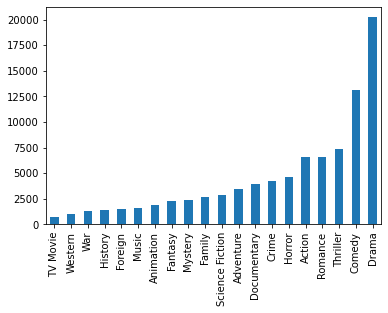

In [73]:
genres.plot(kind = 'bar', x = "genres")

In [74]:
#For some movies, the lists containing genres are empty. They will be replaced with the most occuring
#value of this feature - with Drama.

def impute_genre(genre_list):
    if not genre_list:
        return ['Drama'];
    else:
        return genre_list

In [75]:
movies_dataset['genres'] = movies_dataset['genres'].apply(lambda x: impute_genre(x))

In [76]:
#Now we are going to create single columns for each genre. These columns will be filled with zeros at the beginning.
#Secondly, we are going to map all genres for a given movie to these new columns.

In [77]:
genres.index.values

array(['TV Movie', 'Western', 'War', 'History', 'Foreign', 'Music',
       'Animation', 'Fantasy', 'Mystery', 'Family', 'Science Fiction',
       'Adventure', 'Documentary', 'Crime', 'Horror', 'Action', 'Romance',
       'Thriller', 'Comedy', 'Drama'], dtype=object)

In [78]:
def create_columns(movies_dataset):
    for genre in genres.index.values:
        movies_dataset[genre] = movies_dataset.apply(lambda _: '0', axis=1);
    return movies_dataset

In [79]:
create_columns(movies_dataset)

,budget,genres,popularity,revenue,title,vote_average,vote_count,language_fr,language_other,company_small_company,...,Science Fiction,Adventure,Documentary,Crime,Horror,Action,Romance,Thriller,Comedy,Drama
0,30000000,"[Animation, Comedy, Family]",21.9469,373554033.0,Toy Story,7.7,5415.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,65000000,"[Adventure, Fantasy, Family]",17.0155,262797249.0,Jumanji,6.9,2413.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,"[Romance, Comedy]",11.7129,0.0,Grumpier Old Men,6.5,92.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16000000,"[Comedy, Drama, Romance]",3.85949,81452156.0,Waiting to Exhale,6.1,34.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,[Comedy],8.38752,76578911.0,Father of the Bride Part II,5.7,173.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,0,"[Drama, Family]",0.072051,0.0,Subdue,4.0,1.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
45462,0,[Drama],0.178241,0.0,Century of Birthing,9.0,3.0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
45463,0,"[Action, Drama, Thriller]",0.903007,0.0,Betrayal,3.8,6.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
45464,0,[Drama],0.003503,0.0,Satan Triumphant,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [80]:
#Mapping genres to corresponding columns.

def impute_genre_in_corresponding_column(row):
    for i in movies_dataset['genres'][row]:
        movies_dataset.loc[row, i] = 1;

In [81]:
for index, row in movies_dataset.iterrows():
    impute_genre_in_corresponding_column(index)

In [82]:
movies_dataset.drop(['genres'], axis = 1, inplace = True)

In [83]:
#Check

movies_dataset.head()

,budget,popularity,revenue,title,vote_average,vote_count,language_fr,language_other,company_small_company,company_unknown,...,Science Fiction,Adventure,Documentary,Crime,Horror,Action,Romance,Thriller,Comedy,Drama
0,30000000,21.9469,373554033.0,Toy Story,7.7,5415.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,65000000,17.0155,262797249.0,Jumanji,6.9,2413.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,11.7129,0.0,Grumpier Old Men,6.5,92.0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,16000000,3.85949,81452156.0,Waiting to Exhale,6.1,34.0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
4,0,8.38752,76578911.0,Father of the Bride Part II,5.7,173.0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


# Data cleaning and feature engineering - numeric variables

In [84]:
#Let's firstly change the type of popularity and budget to numeric
#and then let's see whether the numeric variables require any engineering.

movies_dataset['popularity'] = movies_dataset['popularity'].apply(pd.to_numeric, errors = 'coerce')
movies_dataset['budget'] = movies_dataset['budget'].apply(pd.to_numeric, errors = 'coerce')

In [85]:
movies_dataset.describe(include = [np.number])

,budget,popularity,revenue,vote_average,vote_count,language_fr,language_other,company_small_company,company_unknown
count,4.544900e+04,45449.000000,4.544900e+04,45449.000000,45449.000000,45449.000000,45449.000000,45449.000000,45449.000000
mean,4.225880e+06,2.922118,1.121206e+07,5.618803,109.923101,0.053643,0.236397,0.617065,0.261194
std,1.742666e+07,6.005997,6.433980e+07,1.923526,491.367028,0.225313,0.424873,0.486108,0.439290
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.386315,0.000000e+00,5.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000e+00,1.128080,0.000000e+00,6.000000,10.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000e+00,3.679700,0.000000e+00,6.800000,34.000000,0.000000,0.000000,1.000000,1.000000
max,3.800000e+08,547.488298,2.787965e+09,10.000000,14075.000000,1.000000,1.000000,1.000000,1.000000


In [86]:
#Features: popularity, vote average and vote count have values that look reasonable. 

#However, there are two issues: 

#(1) The minimum value for revenue and budget is 0 and in a real world, this should not happen.
#Below we see that there are more than 34000 rows where both values are 0.
#Following an intuition we might assume that they are very important in modelling the final
#movies' popularity and also these are the only ones related to the model's financial aspect.
#It means that rows where both are equal 0 needs to be deleted.

#But in order not to lose more data, the idea is that for rows where only one of those
#(only budget or only revenue) is missing, we may create a helper model estimating the missing one
#using the existing one plus some other variables; noting that of course we cannot use the dependent 
#variable of the main model - popularity.

#(2) Features have values with very different ranges. The first model that will be developed 
# (the helper model that we will use to impute missing revenue/budget) will be a linear regression
#model and this technique does not require features to be standardized (we are not going to include 
#polynomial or interaction terms. If we were going to do that, standardization would be required).

#However, later on while building the final model, if we want to use Lasso/Rigde regression or SVM, they
#would need to be standardized.

In [87]:
#How many rows are there for which both revenue and budget are missing; and how many for which only one is missing?

movies_dataset[(movies_dataset['revenue'] == 0) & (movies_dataset['budget'] == 0)].count()[0]

34532

In [88]:
movies_dataset[(movies_dataset['revenue'] == 0) & (movies_dataset['budget'] != 0)].count()[0]

3509

In [89]:
movies_dataset[(movies_dataset['budget'] == 0) & (movies_dataset['revenue'] != 0)].count()[0]

2027

In [90]:
#The below dataset does not contain rows where both budget and revenue missing - from now on, we are working on this one.

movies_new = movies_dataset[~((movies_dataset['revenue'] == 0) & (movies_dataset['budget'] == 0))]

In [91]:
#We need to reset the old index, because later on, after scaling numeric variables, we will be replacing underlying values in 
#movies_new dataframe and indices need to match each other with those from dataframe called num_variables, created a few lines
#below.

movies_new.reset_index(inplace = True)

In [92]:
movies_new.drop(['index'], axis = 1, inplace = True)

C:\Users\Patrycja\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [93]:
#Scaling variables.

from sklearn.preprocessing import StandardScaler

In [94]:
scaler = StandardScaler()

In [95]:
num_variables = ['budget', 'revenue', 'vote_average', 'vote_count']

In [96]:
scaler.fit(movies_new[num_variables])

StandardScaler()

In [97]:
movies_new[num_variables].head()

,budget,revenue,vote_average,vote_count
0,30000000,373554033.0,7.7,5415.0
1,65000000,262797249.0,6.9,2413.0
2,16000000,81452156.0,6.1,34.0
3,0,76578911.0,5.7,173.0
4,60000000,187436818.0,7.7,1886.0


In [98]:
scaled_features = scaler.transform(movies_new[num_variables])

In [99]:
dataframe_features = pd.DataFrame(scaled_features,columns = ['budget', 'revenue', 'vote_average', 'vote_count'])

In [100]:
#Check

dataframe_features.head()

,budget,revenue,vote_average,vote_count
0,0.386758,2.618958,1.344113,5.321016
1,1.477793,1.731567,0.702553,2.136703
2,-0.049655,0.278618,0.060993,-0.386775
3,-0.548414,0.239573,-0.259787,-0.239334
4,1.321930,1.127774,1.344113,1.577698


In [101]:
for feature in num_variables:
    movies_new[feature] = dataframe_features[feature]

<ipython-input-101-a58ab869850a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_new[feature] = dataframe_features[feature]


In [102]:
#Variables are scaled, we can move on. We will construct two linear regression models
#and use them on rows where budget/revenue is equal to zero in order to estimate the
#real values of the missing variable. 

#In order to do it, we need to construct models using a subset of the original dataset
#where both revenue and budget are nonzero. 
#This subset, however, needs to be split into training and test dataset. Fortunately, we have 5000
#movies with both revenue & budget nonzero values available, so taking 30% of those into the test dataset
#we may conclude it is enough to esimate the test error. In case we had much smaller dataset, instead of
#this technique we would choose some resampling method.

#So, we are going to fit these two models on the training dataset and then evaluate their performance on the
#test dataset. 
#Let us see a correlation matrix with numeric variables, and also some charts that will answer the question
#whether including some dummy variables like production company, movie language
#might provide a meaningful contribution to the model.

<AxesSubplot:>

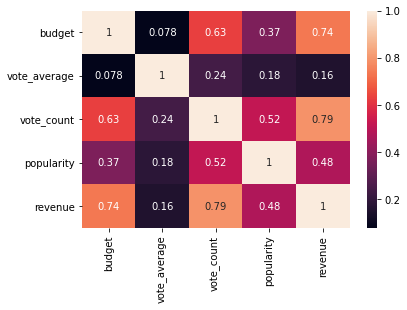

In [103]:
sns.heatmap(movies_new[['budget', 'vote_average', 'vote_count', 'popularity', 'revenue']].corr(), annot = True)

In [104]:
#To be continued